# A Semi-Supervised Approach for Trajectory Segmentation to Identify Different Moisture Processes in the Atmosphere


We adopt the **CoExDBSCAN** algorithm for trajectory segmentation by formulating a constraint on the {H2O,δD} pair distribution to differentiate multiple phases of a trajectory.

Finally, we extract information about the regression coefficients for each phase and comparing the distribution of coefficients to theoretical values to identify corresponding atmospheric moisture processes.

In [1]:
import netCDF4

import numpy as np
import geopandas as gp
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import xarray as xr
import statsmodels.api as sm

from tqdm import tqdm

from math import radians, degrees

from scipy.spatial import distance
from scipy.spatial import KDTree

from sklearn.cluster import dbscan
from sklearn.metrics.pairwise import haversine_distances

# Observations

Our goal is to link the global {H2O,δD} pair distribution observed in the MUSICA IASI dataset to different moisture processes that occurred prior to the observation.

In [2]:
df = pd.read_feather("METOP_DATA_single.feather")

In [3]:
gdf = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df.lon, df.lat))

Example global IASI Metop-A/B H2O measurements for morning overpasses at 2016-06-08. H2O values are in parts per million by volume (ppmv) at logarithmic scale.

The observations have been filtered out for best quality, e.g. areas with no data are cloudy/partly cloudy or have a bad vertical resolution.

The red square indicates our area of interest for the trajectory clustering.

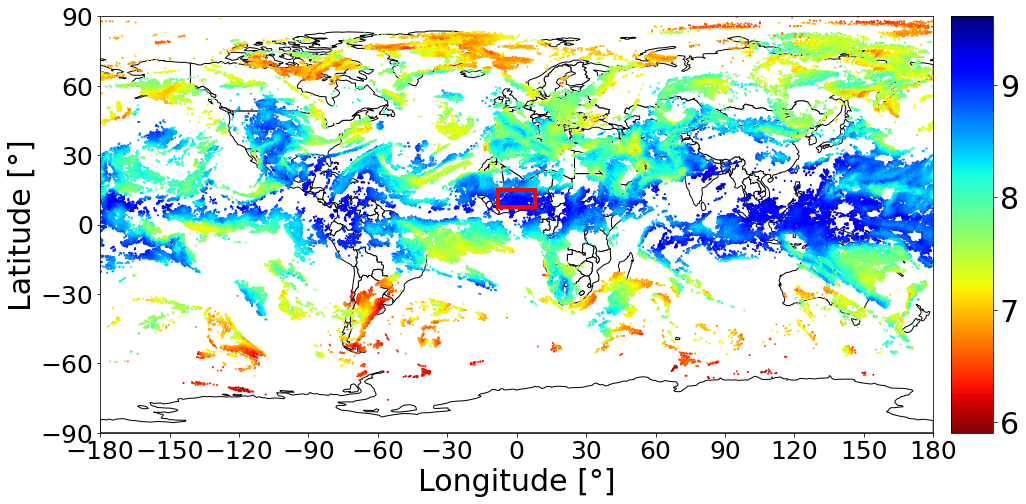

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle

lat_min, lat_max = 7.5, 15
lon_min, lon_max = -8, 8

world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(16,12))

world.plot(color='white',edgecolor='black',ax=ax)

data = df

sc = ax.scatter(x=data.lon,y=data.lat,c=data.h2o_log,cmap='jet_r',s=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)

ax.set_xlabel('Longitude [\N{DEGREE SIGN}]', fontsize=30)
ax.set_ylabel('Latitude [\N{DEGREE SIGN}]', fontsize=30)

ax.tick_params(labelsize=25)

cb = fig.colorbar(sc,cax=cax)
cb.ax.tick_params(labelsize=30)

ax.add_patch(Rectangle((lon_min,lat_min),(lon_max-lon_min),(lat_max-lat_min),
                       edgecolor='red',facecolor='none',lw=4))

ax.set_xlim([-180,180])
ax.set_ylim([-90,90]);
ax.set_xticks(list(range(-180,190,30)))
ax.set_yticks(list(range(-90,100,30)));

In [5]:
#fig.savefig('worldH2O.pdf', bbox_inches='tight')

In [6]:
#%%bash
#pdftoppm -jpeg -r 300 worldH2O.pdf worldH2O.jpg

We choose a timeframe from 2016-06-08 to 2016-07-30 with 61,283 observations to illustrate the dependencies between {H2O,δD} pair distributions and atmospheric processes.

In [7]:
data = pd.read_feather("METOP_DATA.feather")

We plot theoretical predictions of the evolution of δD as a function of H2O (red lines) together with the IASI Metop-A/B {H2O,δD} observations (gray dots).

The contours are at 10\% and 50\% levels, e.g. percentage of the density of observations that lies below the respective line.

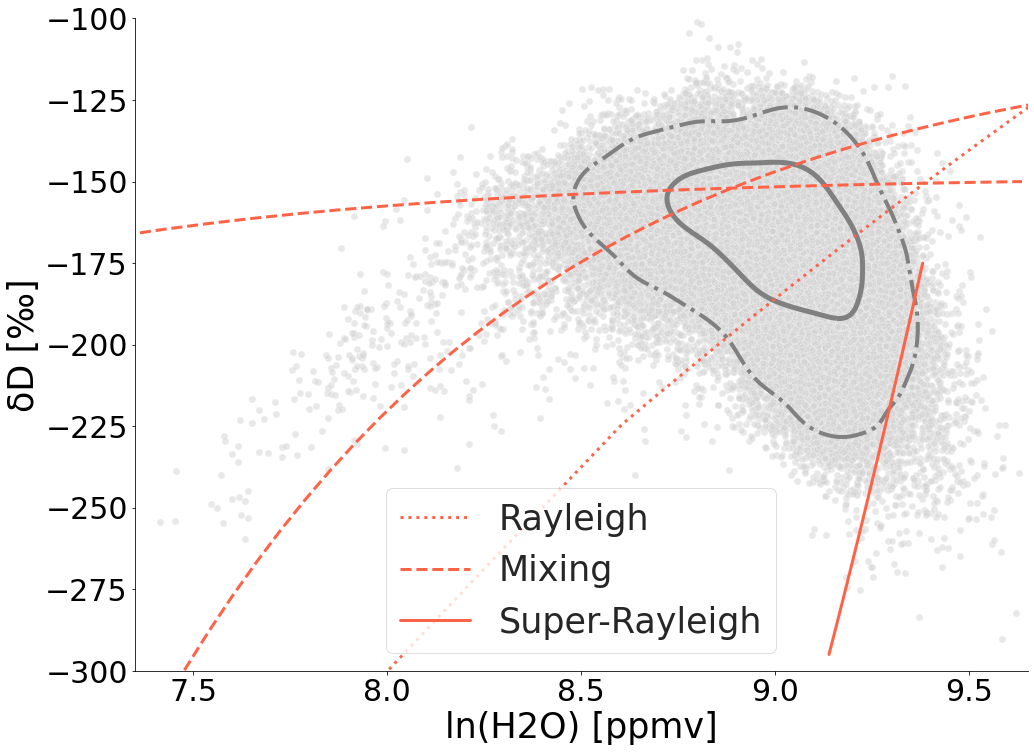

In [8]:
from iso_diag_BE import calc_rayleigh, calc_mixing

fig, ax = plt.subplots(figsize=(16,12))

sns.set_theme()
sns.set_context("paper", font_scale=2)

sns.set_style("ticks")
sns.despine()

sns.scatterplot(x="h2o_log",y="delD",color="lightgray",alpha=0.5,data=data,ax=ax,s=50,legend=False)
sns.kdeplot(x="h2o_log",y="delD",data=data,ax=ax,color="gray",levels=[0.1,0.5],linewidths=[4,5],linestyles=["dashdot","solid"],bw_adjust=1.2)


ax.set_xlabel("ln(H2O) [ppmv]",fontsize=35)
ax.set_ylabel("ẟD [‰]",fontsize=35)

ax.tick_params(labelsize=30)

ax.set_xlim([7.35,9.65])
ax.set_ylim([-300,-100])


rl_list = [ [25, 90, -80] ]

for rl in rl_list:
    h2o_rl, dD_rl, d18_rl, t_rl, p_rl = calc_rayleigh(rl[0], rl[1], rl[2], T_g = -10)
    ax.plot(np.log(h2o_rl), dD_rl, c = "tomato", ls = 'dotted', lw = 3, label = 'Rayleigh')

mx_list = [
 # [[6e2, -700], [3e4, -120]],
  [[5e1, -700], [1.53e4, -150]],
 # [[5e1, -700], [1.53e4, -120]],
  [[1e3, -450], [2.2e4, -120]],
#  [[1e4, -250], [2.6e4, -120]],
  ]

hide = ['','_']
for i, mx in enumerate(mx_list):
    h2o_mx, dD_mx = calc_mixing(p0 = mx[0], p1 = mx[1])
    ax.plot(np.log(h2o_mx), dD_mx, c = "tomato", ls = 'dashed', lw = 3, label = hide[i]+'Mixing')

srl_list = [ [13, 80,  -175, 1.5],]
            #[22, 100, -110, 1.3] ]

lxl = None
for sx, srl in enumerate(srl_list):
    if lxl == None:
        if sx == 0:
            lx = 100
        else:
            lx = 130
    else:
        lx = lxl[sx]

    h2o_sr, dD_sr, _, _, _ = calc_rayleigh(srl[0], srl[1], srl[2], f = srl[3], T_g = -10)
    ax.plot(np.log(h2o_sr[:lx]), dD_sr[:lx], c = "tomato", ls = 'solid', lw = 3, label = hide[sx]+'Super-Rayleigh')


ax.legend(prop={'size': 35});

In [9]:
#fig.savefig('H2OdeltaD.pdf', bbox_inches='tight')

In [10]:
#%%bash
#pdftoppm -jpeg -r 300 H2OdeltaD.pdf H2OdeltaD.jpg

# Trajectories

However, observations in the MUSICA IASI dataset are only available for cloud-free conditions and limited vertical resolution.

Therefore, we apply our segmentation algorithm to modelled {H2O,ẟD} fields and modelled data of Lagrangian air parcel trajectories.
As model data we use the high-resolution data from the regional isotope-enabled atmospheric model COSMO-iso.

Analysing the model data instead of the observational data allows us to draw scientifically sound conclusions about the MUSICA IASI observed {H2O,ẟD} pair distributions.

In [11]:
ds = xr.open_dataset('trajectories_new.nc')

In [12]:
data = ds.to_dataframe()
data = data.reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149680 entries, 0 to 2149679
Data columns (total 21 columns):
 #   Column    Dtype  
---  ------    -----  
 0   ntim      int64  
 1   ntra      int64  
 2   time      float32
 3   lon       float32
 4   lat       float32
 5   z         float32
 6   QV        float32
 7   QV2H      float32
 8   QR        float32
 9   TOT_PREC  float32
 10  HPBL      float32
 11  QC        float32
 12  P         float32
 13  T         float32
 14  QI        float32
 15  QS        float32
 16  QR2H      float32
 17  QS2H      float32
 18  dz        float32
 19  dD        float32
 20  h2o_vmr   float32
dtypes: float32(19), int64(2)
memory usage: 188.6 MB


In [13]:
ntra_drop = []
for ntra, group in tqdm(data.groupby("ntra")):
    if group.isna().any().any():
        ntra_drop.append(ntra)

100%|██████████| 12720/12720 [00:06<00:00, 1874.28it/s]


In [14]:
for ntra in tqdm(ntra_drop):
    data[data["ntra"] == ntra] = np.nan
    
data.dropna(inplace=True)
data.info()

100%|██████████| 867/867 [00:48<00:00, 17.90it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2003157 entries, 0 to 2149679
Data columns (total 21 columns):
 #   Column    Dtype  
---  ------    -----  
 0   ntim      float64
 1   ntra      float64
 2   time      float32
 3   lon       float32
 4   lat       float32
 5   z         float32
 6   QV        float32
 7   QV2H      float32
 8   QR        float32
 9   TOT_PREC  float32
 10  HPBL      float32
 11  QC        float32
 12  P         float32
 13  T         float32
 14  QI        float32
 15  QS        float32
 16  QR2H      float32
 17  QS2H      float32
 18  dz        float32
 19  dD        float32
 20  h2o_vmr   float32
dtypes: float32(19), float64(2)
memory usage: 191.0 MB


To illustrate and group our trajectory dataset, we use **DBSCAN** on a precomputed distance matrix.

For the precomputed distance matrix, each trajectory is converted to a 4x169 = 676 dimensional vector;

the latitudinal (1) and longitudinal (2) difference for each time point to the arrival coordinates
the bearing (3) for each consecutive point and
the scaled height difference (4) for each consecutive point, 169 points each.

In [15]:
def bearing(lat1, lon1, lat2, lon2):
    return np.arctan2(
        (np.cos((lat2)) * np.sin((lon2-lon1))),
        (np.cos((lat1)) * np.sin((lat2)) - np.sin((lat1)) * np.cos((lat2)) * np.cos((lon2-lon1)))
    )

In [16]:
data["lat_r"] = data.lat.apply(radians)
data["lon_r"] = data.lon.apply(radians)

In [17]:
for ntra, group in tqdm(data.groupby("ntra")):
    g = group.sort_values("ntim", ascending=False)
    data.loc[g.index, "bearing"] = [bearing(lat1, lon1, lat2, lon2) for (lat1, lon1), (lat2, lon2) in
                                    zip(g[["lat_r","lon_r"]].values, g[["lat_r","lon_r"]].shift(-1).values)]
    data.loc[g.index, "distance"] = haversine_distances(g[["lat_r","lon_r"]].values, np.zeros((1,2))) * 6371000/1000
    data.loc[g.index, "z_diff"] = g.z.diff().fillna(value=0.0)
    data.loc[g.index, "lat_diff"] = g.lat_r.diff().fillna(value=0.0)
    data.loc[g.index, "lon_diff"] = g.lon_r.diff().fillna(value=0.0)

100%|██████████| 11853/11853 [04:59<00:00, 39.57it/s]


In [18]:
data["bearing"] = data.bearing.fillna(value=0.0)

In [19]:
arr = []
for ntra, group in tqdm(data.groupby("ntra")):
    arr.append(np.concatenate([(group[["lat_r","lon_r"]] - group[["lat_r","lon_r"]].iloc[0]).values, group.bearing.values, group.z_diff / 1e3], axis=None))
arr = np.array(arr)

100%|██████████| 11853/11853 [00:27<00:00, 432.32it/s]


In [20]:
arr.shape

(11853, 676)

In [21]:
dm = distance.cdist(arr,arr)

In [22]:
dm

array([[ 0.        , 36.27892403, 33.97698272, ..., 28.72040753,
        32.35552819, 41.74770265],
       [36.27892403,  0.        , 33.71768372, ..., 39.64409131,
        42.36371869, 41.47380858],
       [33.97698272, 33.71768372,  0.        , ..., 29.78539569,
        30.17147749, 23.54039308],
       ...,
       [28.72040753, 39.64409131, 29.78539569, ...,  0.        ,
        24.0019585 , 34.06365795],
       [32.35552819, 42.36371869, 30.17147749, ..., 24.0019585 ,
         0.        , 35.41230245],
       [41.74770265, 41.47380858, 23.54039308, ..., 34.06365795,
        35.41230245,  0.        ]])

We can use grid-search to determine suitable parameters for **DBSCAN**.

In [23]:
# eps = 12
# min_samples = 100

# for eps in [10,11,12,13,14,15,16,17,18,19,20]:
#     for min_samples in [10,20,30,40,50,60,70,80,90,100,110,120]:
#         core_samples, cluster_labels = dbscan(dm, eps=eps, min_samples=min_samples, metric="precomputed")

#         l,c = np.unique(cluster_labels, return_counts=True)

#         print(f"{eps} {min_samples} {l} {c}")

In [24]:
eps = 10
min_samples = 20


core_samples, cluster_labels = dbscan(dm, eps=eps, min_samples=min_samples, metric="precomputed")

l,c = np.unique(cluster_labels, return_counts=True)

print(f"{eps} {min_samples} {l} {c}")

10 20 [-1  0  1  2  3  4  5] [8659 1100 1875  122   48   24   25]


In [25]:
df = data.copy()
df = df.reset_index()

df['label'] = np.tile(cluster_labels, int(df.ntim.max()) + 1)
df['point'] = df.index
df["type"] = "MIX"
df["h2o_log"] = np.log(df["h2o_vmr"])
df["h2o_inv"] = np.reciprocal(df["h2o_vmr"])
df["h2o_dD"] = df["dD"] * df["h2o_vmr"]
df["dD_ln"] = np.log(df["dD"] / 1000 + 1)
df = df.dropna()

Following illustrates 3,194 trajectories out of 11,853 that have been colored according to their geographical closeness, bearing similarity and height difference along each individual trajectory.

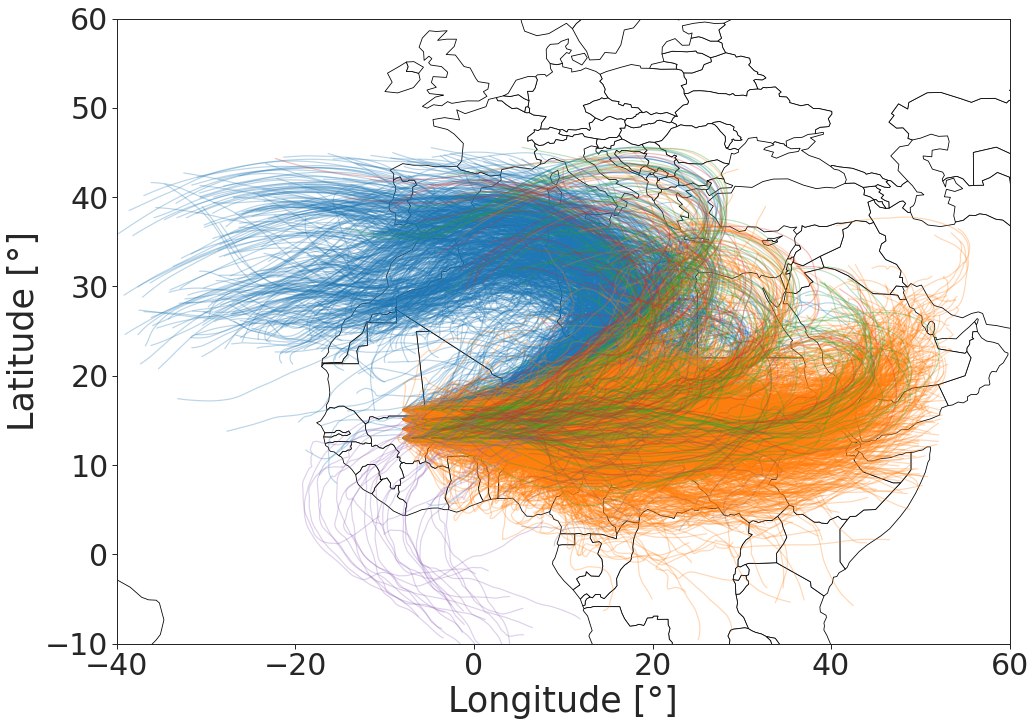

In [26]:
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(16,12))

colors = np.tile(list(matplotlib.colors.TABLEAU_COLORS.values()), 100)

lal = -10 # latitude low boundery
lah = 60 # latitude high boundery
lol = -40 # longitude low boundery
loh = 60 # longitude high boundery

world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')

ax.set_xlim(lol,loh)
ax.set_ylim(lal,lah)


grouped = df.groupby('label')

legend_lines = []
legend_names = []

handles = []

for name, group in grouped:
    #print(name)
    if name == -1:
        continue
    for n, g in group.groupby('ntra'):
        ax.plot(g.lon, g.lat, alpha=0.3, c=colors[name])

ax.set_xlabel('Longitude [\N{DEGREE SIGN}]', fontsize=35)
ax.set_ylabel('Latitude [\N{DEGREE SIGN}]', fontsize=35);

ax.tick_params(labelsize=30);

In [27]:
#fig.savefig('trajectories.pdf', bbox_inches='tight')

In [28]:
#%%bash
#pdftoppm -jpeg -r 300 trajectories.pdf trajectories.jpg

We distinguish between RAIN and MIXing events.

In [29]:
for _, group in tqdm(df.groupby("ntra")):
    df.loc[group.index, "qr_mean"] = group["QR"].rolling(3).mean()

df.loc[df["qr_mean"] > 0.05, "type"] = "RAIN"

for _, group in tqdm(df.groupby("ntra")):
    g = group.loc[group["type"] == "RAIN"]
    if not g.empty:
        index = np.union1d(g.ntim - 1, np.union1d(g.ntim, g.ntim + 1))
        if index.min() < 3:
            index = np.union1d(np.array([0, 1]), index)
        gt = group.set_index("ntim")
        point_idx = gt.loc[gt.index.intersection(index)].point
        df.loc[point_idx, "type"] = "RAIN"

100%|██████████| 11853/11853 [01:08<00:00, 173.82it/s]


Following implements the **CoExDBSCAN** algorithm.

In [30]:
def coexdbscan(points, eps=5, minPts=10, delta=3.):

    unclassified = np.inf
    noise = -1
    nextLabel = noise

    labels = np.full(points.shape[0], unclassified)

    tree = KDTree(points[:, 0].reshape(-1, 1))
    neighbours = tree.query_ball_point(points[:, 0].reshape(-1, 1), eps)


    for idx, p in enumerate(points):
        if labels[idx] != unclassified:
            continue
        if len(neighbours[idx]) < minPts:
            labels[idx] = noise
            continue

        nextLabel += 1

        labels[idx] = nextLabel
        seeds = set(neighbours[idx])
        seeds.remove(idx)

        while len(seeds) > 0:
            seed = seeds.pop()
            if labels[seed] != unclassified:
                continue

            cluster_points = np.vstack((points[labels == nextLabel],
                                        points[seed]))[:, 1:]

            X = cluster_points[:, 0].reshape(-1, 1)
            y = cluster_points[:, 1]
            X = sm.add_constant(X)
            reg = sm.OLS(y, X).fit()

            mse = np.power(reg.resid[:-1], 2).mean()
            if np.power(reg.resid[-1], 2) < delta * mse:
                labels[seed] = nextLabel
                if len(neighbours[seed]) < minPts:
                    continue

                seeds.update(neighbours[seed])

    #print(labels)
    # mark clusters smaller minPts noise
    label, count = np.unique(labels, return_counts=True)
    idx = np.argwhere(count < minPts).ravel()
    for i in idx:
        labels[labels == label[i]] = -1
    
    return labels

We apply the **CoExDBSCAN** according to the algorithm outlined in the paper.

In [31]:
for label in tqdm(np.unique(df.label)):
    for ntra, group in df[(df["label"] == label) & (df["type"] == "RAIN")].groupby("ntra"):
        d = group.sort_values("ntim", ascending=True)
        phase = coexdbscan(d[["time","h2o_log","dD_ln"]].values, eps=2, minPts=3, delta=2.)
        
        #print(ntra, phase)
        df.loc[d.index, "phase_bwd"] = phase
        
        d = group.sort_values("ntim", ascending=False)
        phase = coexdbscan(d[["time","h2o_log","dD_ln"]].values, eps=2, minPts=3, delta=2.)
        
        #print(ntra, phase)
        df.loc[d.index, "phase_fwd"] = phase

100%|██████████| 7/7 [00:46<00:00,  6.63s/it]


In [32]:
for label in tqdm(np.unique(df.label)):
#     if label == -1:
#         continue
    for (ntra, phase), group in df[(df["label"] == label) & (df["type"] == "RAIN")].groupby(["ntra","phase_bwd"]):
        if phase == -1:
            continue
            
        X = group.h2o_log.values.reshape(-1,1)
        y = group.dD_ln.values
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()

        df.loc[group.index, "intercept_bwd"] = reg.params[0]
        df.loc[group.index, "coef_bwd"] = reg.params[1]
        df.loc[group.index, "metric_bwd"] = np.power(reg.resid, 2).sum()
        df.loc[group.index, "f_pvalue_bwd"] = reg.f_pvalue
        
    for (ntra, phase), group in df[(df["label"] == label) & (df["type"] == "RAIN")].groupby(["ntra","phase_fwd"]):
        if phase == -1:
            continue
            
        X = group.h2o_log.values.reshape(-1,1)
        y = group.dD_ln.values
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()

        df.loc[group.index, "intercept_fwd"] = reg.params[0]
        df.loc[group.index, "coef_fwd"] = reg.params[1]
        df.loc[group.index, "metric_fwd"] = np.power(reg.resid, 2).sum()
        df.loc[group.index, "f_pvalue_fwd"] = reg.f_pvalue
        
        
    for ntra, group in df[(df["label"] == label) & (df["type"] == "RAIN")].groupby("ntra"):
        if group.metric_bwd.sum() < group.metric_fwd.sum():
            df.loc[group.index, "phase"] = group.phase_bwd
            df.loc[group.index, "coef"] = group.coef_bwd
            df.loc[group.index, "intercept"] = group.intercept_bwd
            df.loc[group.index, "f_pvalue"] = group.f_pvalue_bwd
        else:
            df.loc[group.index, "phase"] = group.phase_fwd
            df.loc[group.index, "coef"] = group.coef_fwd
            df.loc[group.index, "intercept"] = group.intercept_fwd
            df.loc[group.index, "f_pvalue"] = group.f_pvalue_fwd

100%|██████████| 7/7 [03:23<00:00, 29.13s/it] 


In [33]:
# df.to_feather("TRAJECTORY_DATA.feahter")

In [34]:
# df = pd.read_feather("TRAJECTORY_DATA.feahter")

We can analyse the regression coefficients (slope of linear regression line) for all segments as a result of our semi-supervised trajectory segmentation withstatistical significance (p-value < 0.05).

In [35]:
data_plot = df[(pd.notna(df["coef"]))]
data_plot = data_plot[data_plot.f_pvalue < 0.05]

In [36]:
coeficients = []
for coef, group in data_plot.groupby("coef"):
    coeficients.append(coef)

In [37]:
df_coef = pd.DataFrame()
df_coef["coef"] = coeficients

Precentage of regression coefficients < 0.0.

In [38]:
(df_coef.coef < 0.0).sum() / df_coef.size * 100

7.562117392870003

Precentage of regression coefficients between 0.0 and 0.1.

In [39]:
((df_coef.coef >= 0.0) & (df_coef.coef < 0.1)).sum() / df_coef.size * 100

58.62441483615412

Precentage of regression coefficients > 0.1.

In [40]:
(df_coef.coef >= 0.1).sum() / df_coef.size * 100

33.813467770975876

In [41]:
df_coef["Coefficient"] = "< 0.0 (~7.56 %)"

In [42]:
df_coef.loc[df_coef.coef >= 0, "Coefficient"] = "[0.0,0.1[ (~58.62 %)"
df_coef.loc[df_coef.coef >= 0.1, "Coefficient"] = ">= 0.1 (~33.82 %)"

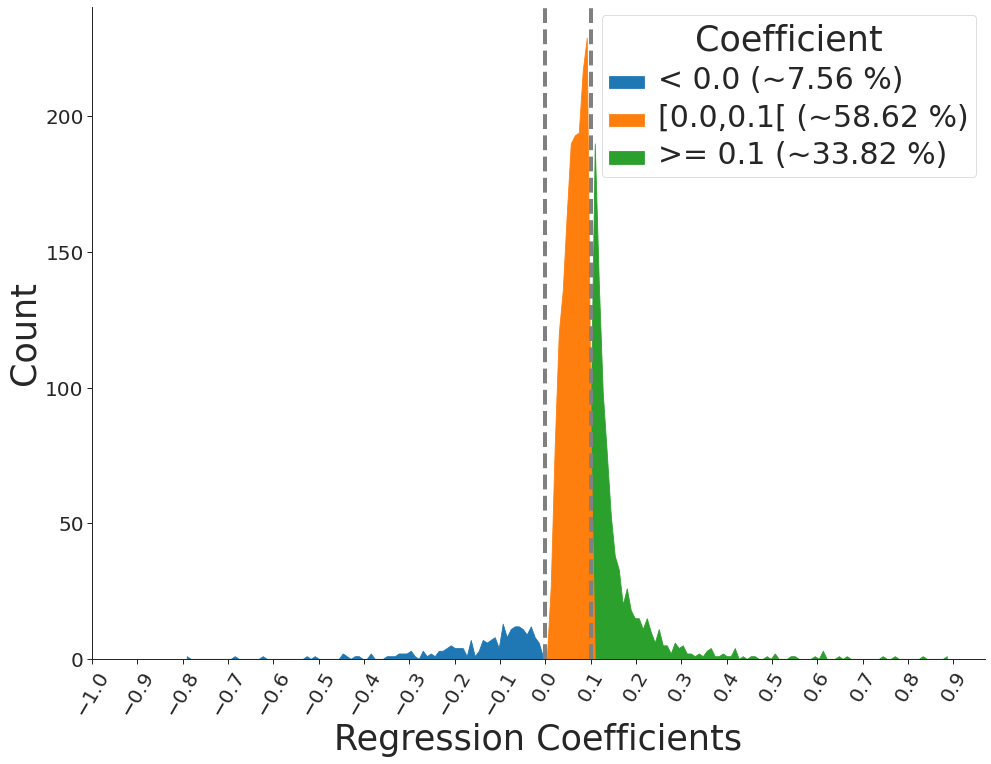

In [43]:
fig, ax = plt.subplots(figsize=(16,12))

sns.set_theme()
sns.set_context("paper", font_scale=2)

sns.set_style("ticks")
sns.despine()

g = sns.histplot(x="coef",hue="Coefficient",ax=ax,data=df_coef[df_coef.coef.between(-1,1)],palette='tab10',alpha=1.0,element="poly")

ax.set_xlabel("Regression Coefficients",fontsize=35)
ax.set_ylabel("Count",fontsize=35)
ax.axvline(ls="--",c="gray",lw=4)
ax.axvline(x=0.1,ls="--",c="gray",lw=4)

plt.setp(g.get_legend().get_title(), fontsize='35')
plt.setp(g.get_legend().get_texts(), fontsize='30')
ax.tick_params(labelsize=20)
ax.set_xticks(np.arange(-1.0,1.0,0.1))
plt.xticks(rotation=60);

In [44]:
#fig.savefig('coef_hist.pdf', bbox_inches='tight')

In [45]:
data_plot["Coefficient"] = "< 0"

In [46]:
data_plot.loc[data_plot.coef >= 0.0, "Coefficient"] = "[0.0,0.1["
data_plot.loc[data_plot.coef >= 0.1, "Coefficient"] = ">= 0.1"

We can also analyse the distribution of regression coefficients in the {H2O,δD} value space (gray all values) for coefficients below 0.0 (blue contours), between 0.0 and 0.1 (orange contours) and above 0.1 (green contours); contour levels are at 10% and 50%.

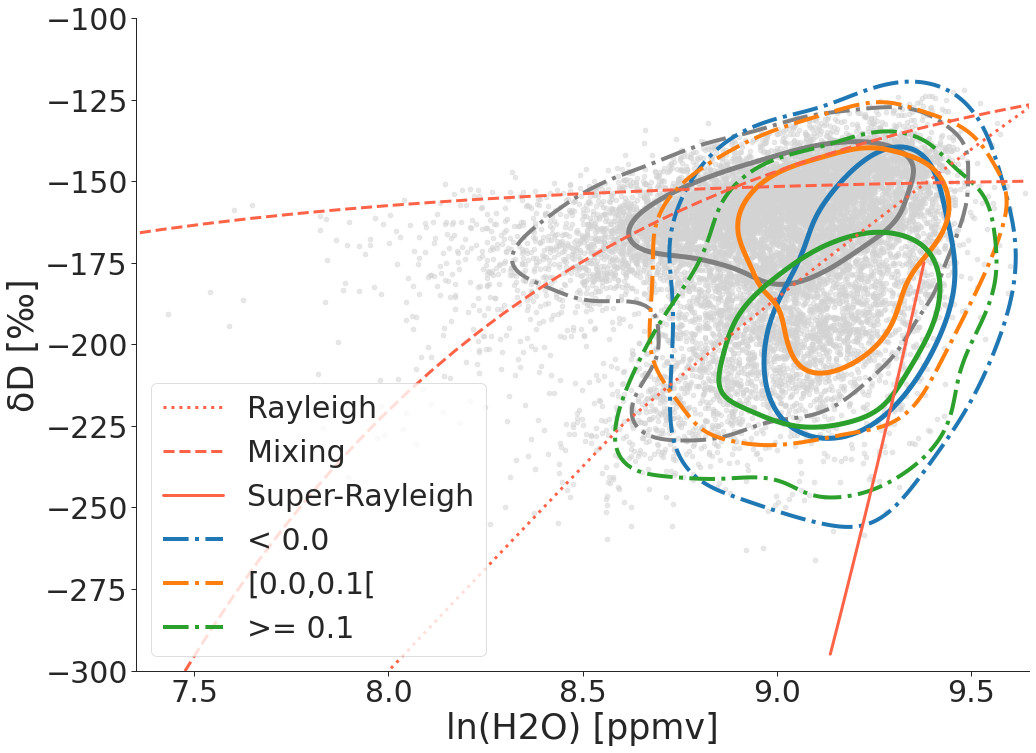

In [47]:
fig, ax = plt.subplots(figsize=(16,12))

sns.set_theme()
sns.set_context("paper", font_scale=2)

sns.set_style("ticks")
sns.despine()


ax.scatter(df[df.ntim == 0].h2o_log, df[df.ntim == 0].dD,c="lightgray",alpha=0.5)
sns.kdeplot(x="h2o_log",y="dD",data=df[df.ntim == 0],ax=ax,color="gray",levels=[0.1,0.5],
            linewidths=[4,5],linestyles=["dashdot","solid"],bw_adjust=1.2)

h2o = []
dD = []

for ntra, group in data_plot[data_plot.coef < 0.0].groupby("ntra"):
    if (group.ntim.min() <= 5*24):
        row = df[df.ntra == ntra].loc[df['ntim'] == 0]
        
        h2o.append(row.h2o_log.values[0])
        dD.append(row.dD.values[0])

sns.kdeplot(x=np.array(h2o),y=np.array(dD),ax=ax,color="tab:blue",levels=[0.1,0.5],
            linewidths=[4,5],linestyles=["dashdot","solid"],bw_adjust=1.2,label="< 0.0")
        
h2o = []
dD = []

for ntra, group in data_plot[(data_plot.coef >= 0.0) & (data_plot.coef < 0.1)].groupby("ntra"):
    if (group.ntim.min() <= 5*24):
        row = df[df.ntra == ntra].loc[df['ntim'] == 0]
        
        h2o.append(row.h2o_log.values[0])
        dD.append(row.dD.values[0])
        

sns.kdeplot(x=np.array(h2o),y=np.array(dD),ax=ax,color="tab:orange",levels=[0.1,0.5],
            linewidths=[4,5],linestyles=["dashdot","solid"],bw_adjust=1.2,label="[0.0,0.1[")

h2o = []
dD = []

for ntra, group in data_plot[data_plot.coef >= 0.1].groupby("ntra"):
    if (group.ntim.min() <= 5*24):
        row = df[df.ntra == ntra].loc[df['ntim'] == 0]
        
        h2o.append(row.h2o_log.values[0])
        dD.append(row.dD.values[0])

sns.kdeplot(x=np.array(h2o),y=np.array(dD),ax=ax,color="tab:green",levels=[0.1,0.5],
            linewidths=[4,5],linestyles=["dashdot","solid"],bw_adjust=1.2,label=">= 0.1")
        
rl_list = [ [25, 90, -80] ]

for rl in rl_list:
    h2o_rl, dD_rl, d18_rl, t_rl, p_rl = calc_rayleigh(rl[0], rl[1], rl[2], T_g = -10)
    ax.plot(np.log(h2o_rl), dD_rl, c = "tomato", ls = 'dotted', lw = 3, label = 'Rayleigh')

mx_list = [
 # [[6e2, -700], [3e4, -120]],
  [[5e1, -700], [1.53e4, -150]],
 # [[5e1, -700], [1.53e4, -120]],
  [[1e3, -450], [2.2e4, -120]],
#  [[1e4, -250], [2.6e4, -120]],
  ]

hide = ['','_']
for i, mx in enumerate(mx_list):
    h2o_mx, dD_mx = calc_mixing(p0 = mx[0], p1 = mx[1])
    ax.plot(np.log(h2o_mx), dD_mx, c = "tomato", ls = 'dashed', lw = 3, label = hide[i]+'Mixing')

srl_list = [ [13, 80,  -175, 1.5],]
            #[22, 100, -110, 1.3] ]

lxl = None
for sx, srl in enumerate(srl_list):
    if lxl == None:
        if sx == 0:
            lx = 100
        else:
            lx = 130
    else:
        lx = lxl[sx]

    h2o_sr, dD_sr, _, _, _ = calc_rayleigh(srl[0], srl[1], srl[2], f = srl[3], T_g = -10)
    ax.plot(np.log(h2o_sr[:lx]), dD_sr[:lx], c = "tomato", ls = 'solid', lw = 3, label = hide[sx]+'Super-Rayleigh')

ax.set_xlabel("ln(H2O) [ppmv]",fontsize=35)
ax.set_ylabel("ẟD [‰]",fontsize=35)

ax.tick_params(labelsize=30)
lg = ax.legend(title_fontsize=30,fontsize=30,markerscale=3,)


ax.set_xlim([7.35,9.65])
ax.set_ylim([-300,-100]);

In [48]:
#fig.savefig('coef_dist.pdf', bbox_inches='tight')

We can also get statistics over all identified phases.

In [49]:
ntra_phase = []

for ntra in tqdm(df[df["type"] == "RAIN"].pivot_table(index="ntra", columns="phase", values="coef").index.values):
    ntra_df = df[df["ntra"] == ntra][df[df["ntra"] == ntra].phase.notna()]
    #print(ntra)
    phases = len(np.unique(ntra_df.phase))
    max_phase = 0
    max_coef = -np.inf
    min_coef = np.inf
    
    for phase, group in ntra_df.groupby("phase"):
#         print(phase,group.f_pvalue.values[0] < 0.05)
#         print(group.coef.values)
#         print(group.ntim.values)
        if len(group) > max_phase:
            max_phase = len(group)
        if group.coef.values[0] > max_coef:
            max_coef = group.coef.values[0]
        if group.coef.values[0] < min_coef:
            min_coef = group.coef.values[0]
            
    ntra_phase.append({"ntra": ntra, "phases": phases, "max_coef": max_coef, "min_coef": min_coef, "max_phase": max_phase})

100%|██████████| 2594/2594 [00:15<00:00, 170.32it/s]


In [50]:
df_ntra_phase = pd.DataFrame(ntra_phase)

In [51]:
df_ntra_phase[df_ntra_phase.phases >= 2].sort_values("max_phase",ascending=False)["ntra"].values

array([ 1596.,  7327., 11003., ...,  7339., 10749.,  4922.])

In [52]:
df_ntra_phase[df_ntra_phase.phases >= 2].sort_values("max_phase",ascending=False)["ntra"].values

array([ 1596.,  7327., 11003., ...,  7339., 10749.,  4922.])

Example trajectory with two rain sequences, which can be identified by the crosses with additional segmentation of a continuous sequences based on the defined constraint for the regression coefficients.  

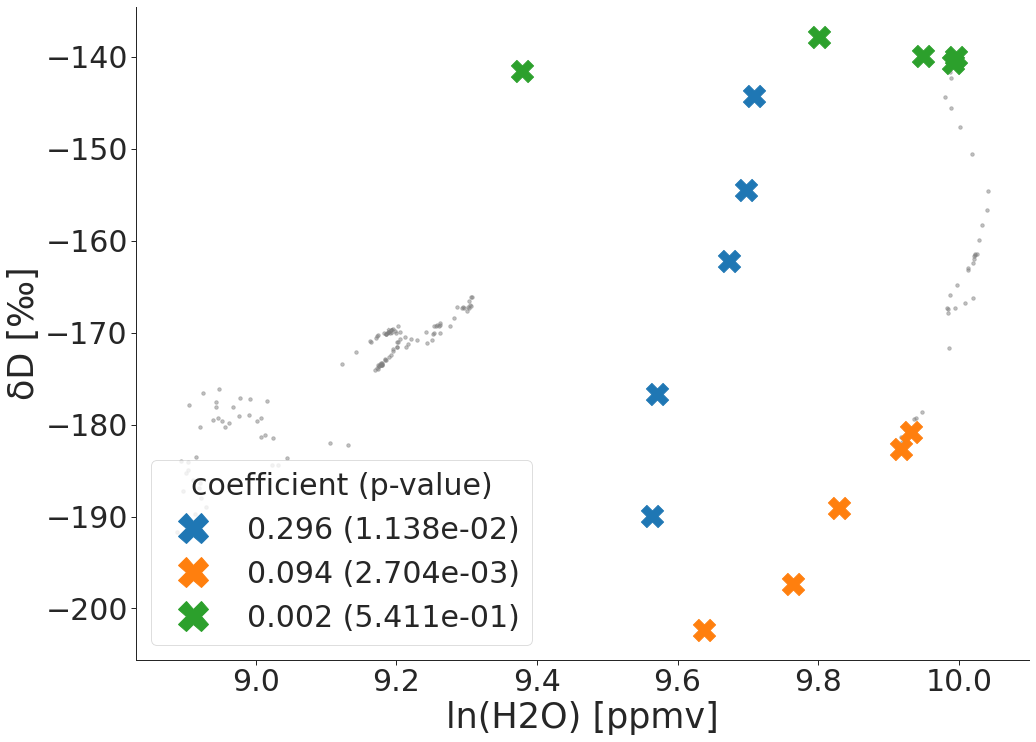

In [53]:
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(16,12))

sns.set_theme()
sns.set_context("paper", font_scale=2)

sns.set_style("ticks")
sns.despine()


data_plot = df[df["ntra"] == 2011].copy()

ax.set_xlabel("ln(H2O) [ppmv]",fontsize=35)
ax.set_ylabel("ẟD [‰]",fontsize=35)

d = data_plot[data_plot["type"] == "RAIN"]
ax.scatter(d.h2o_log, d.dD, s=50, alpha=0.5,c="gray", marker="X")

d = data_plot[data_plot["type"] == "MIX"]
ax.scatter(d.h2o_log, d.dD, s=50, alpha=0.5,c="gray", marker=".")

c = 0
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink']
handles = []
for phase, group in data_plot.groupby("phase"):
    if group.coef.isna().any():
        continue
    ax.scatter(group.h2o_log, group.dD, s=500,marker="X",c=colors[c])
    handles.append(mlines.Line2D([], [], color=colors[c], marker='X', linestyle='None',markersize=30,
                                 label=f'{group.coef.values[0]:.3f} ({group.f_pvalue.values[0]:.3e})'))
    c += 1

ax.tick_params(labelsize=30)
ax.legend(handles=handles,title="coefficient (p-value)",title_fontsize=30,fontsize=30,loc=3);

In [54]:
#fig.savefig('traj_5224_phases.pdf', bbox_inches='tight')
#fig.savefig('traj_2011_phases.pdf', bbox_inches='tight')
#fig.savefig('traj_1893_phases.pdf', bbox_inches='tight')
# 8824

Following illustrate the timely order of events according to the number of hours before arrival from 168 to 0 (dark blue to dark red).

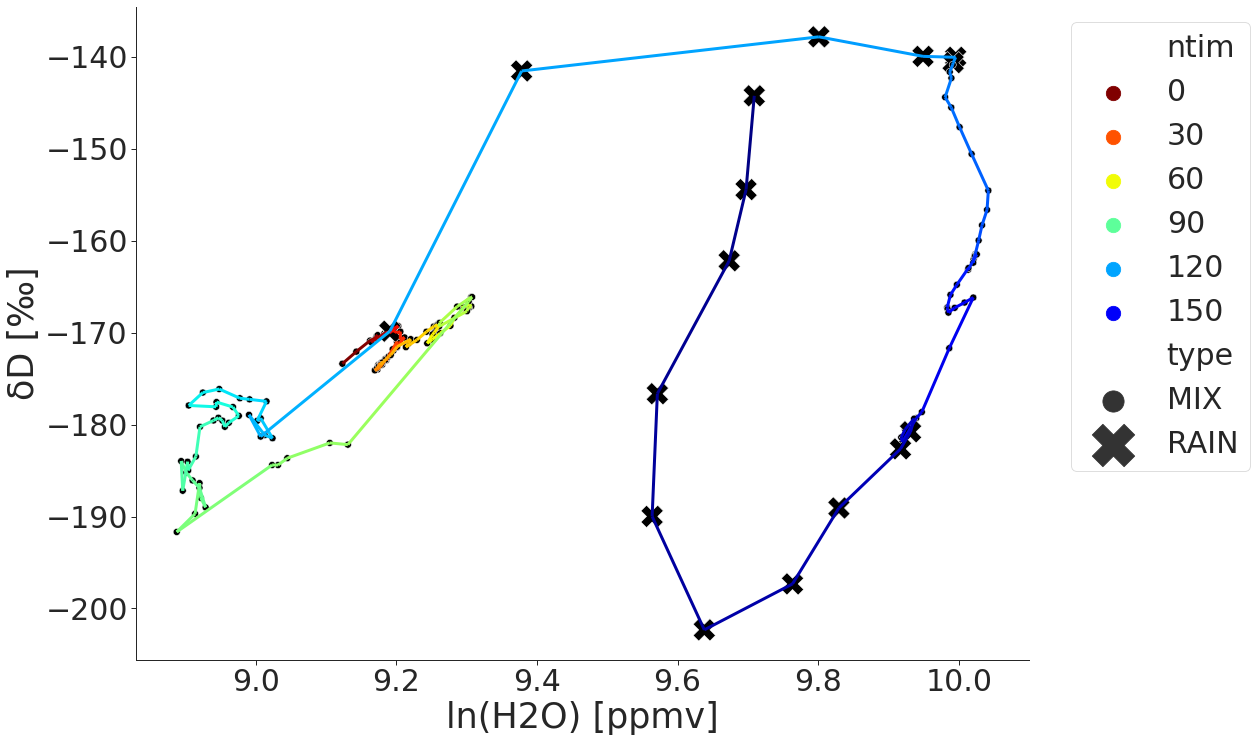

In [55]:
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(16,12))

sns.set_theme()
sns.set_context("paper", font_scale=2)

sns.set_style("ticks")
sns.despine()


data_plot = df[df["ntra"] == 2011].copy()
#data_plot = df[df["ntra"] == 5224].copy()
#data_plot = df[df["ntra"] == 1893].copy()

ax.set_xlabel("ln(H2O) [ppmv]",fontsize=35)
ax.set_ylabel("ẟD [‰]",fontsize=35)

sc = sns.scatterplot(x="h2o_log", y="dD", size="type", sizes=[50,200],
                     data=data_plot, alpha=0.5,
                     hue="ntim", palette="jet_r",
                     style="type", legend=True, ax=ax)

sc.legend(bbox_to_anchor= (1.03, 1),title_fontsize=30,fontsize=30,markerscale=3)

sns.scatterplot(x="h2o_log", y="dD", size="type", sizes=[50,500],
                data=data_plot, alpha=1, color="black",
                style="type", legend=False, ax=ax)

points = np.array([data_plot.h2o_log,data_plot.dD]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=plt.get_cmap('jet_r'),
                    norm=plt.Normalize(0, 168))
lc.set_array(data_plot.ntim)
lc.set_linewidth(3)
ax.tick_params(labelsize=30)

ax.add_collection(lc);

In [56]:
#fig.savefig('traj_5224_time.pdf', bbox_inches='tight')
#fig.savefig('traj_2011_time.pdf', bbox_inches='tight')
#fig.savefig('traj_1893_time.pdf', bbox_inches='tight')